# Задание 4 - Перенос обучения (transfer learning) и тонкая настройка (fine-tuning)

Одной из важнейшних техник в тренировке сетей - использовать заранее натренированные веса на более общей задачи в качестве начальной точки, а потом "дотренировать" их на конкретной.

Такой подход и убыстряет обучение, и позволяет тренировать эффективные модели на маленьких наборах данных.

В этом упражнении мы натренируем классификатор, который отличает хотдоги от не хотдогов!  
(более подробно - https://www.youtube.com/watch?v=ACmydtFDTGs)

Это задание требует доступа к GPU, поэтому его можно выполнять либо на компьютере с GPU от NVidia, либо в [Google Colab](https://colab.research.google.com/).

In [1]:
import json
import os
import csv
import urllib
import io
from io import BytesIO
from PIL import Image

from socket import timeout


In [2]:
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0") # Let's make sure GPU is available!
torch.cuda.is_available()

True

# Имплементируем свой Dataset для загрузки данных

В этом задании мы реализуем свой собственный класс Dataset для загрузки данных. Его цель - загрузить данные с диска и выдать по ним тензор с входом сети, меткой и идентификатором картинки (так будет проще подготовить сабмит для kaggle на тестовых данных).

Вот ссылка, где хорошо объясняется как это делать на примере: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Ваш Dataset должен в качестве количества сэмплов выдать количество файлов в папке и уметь выдавать кортеж из сэмпла, метки по индексу и названия файла.
Если название файла начинается со слов 'frankfurter', 'chili-dog' или 'hotdog' - метка положительная. Иначе отрицательная (ноль).

И не забудьте поддержать возможность трансформации входа (аргумент `transforms`), она нам понадобится!

In [3]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        
        self.folder = folder
        self.image_names = os.listdir(self.folder)
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):        
        # TODO Implement getting item by index
        # Hint: os.path.join is helpful!
        
        img_id = self.image_names[index]

        image_name =os.path.join(self.folder, img_id)
        img = Image.open(image_name)

        y = 0 
        true_hotdog_filenames = ['frankfurter', 'chili-dog', 'hotdog']

        for hotdog_file_prefix in true_hotdog_filenames:
            if hotdog_file_prefix in image_name:
                y = 1
                break
        if self.transform:
            img = self.transform(img)
        
        return img, y, img_id

def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   

# Создаем Dataset для тренировки

И разделяем его на train и validation.
На train будем обучать модель, на validation проверять ее качество, а соревнование Kaggle In-Class проведем на фотографиях из папки test_kaggle.

In [4]:
train_folder = "train_kaggle/"
test_folder = "test_kaggle/"

orig_dataset = HotdogOrNotDataset(train_folder)

# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [5]:
batch_size = 64

data_size = len(train_dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Наши обычные функции для тренировки

In [24]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    start = time.time()
    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("[{0}]Loss: {1:.4f}, Train err: {2:2.2f}%, Val err: {3:2.2f}%".format(
            epoch, 
            ave_loss,
            (1 - train_accuracy)*100,
            (1 - val_accuracy)*100)
        )
    
    print("elapsed", time.time() - start, "seconds")
    return loss_history, train_history, val_history

def multiclass_accuracy(prediction, ground_truth):
    '''
    Computes metrics for multiclass classification

    Arguments:
    prediction, np array of int (num_samples) - model predictions
    ground_truth, np array of int (num_samples) - true labels

    Returns:
    accuracy - ratio of accurate predictions to total samples
    '''
    # print(prediction, ground_truth)
    # TODO: Implement computing accuracy
    
    num_samples = prediction.shape[0]
    correct = 0
    for i in range(num_samples):
        if prediction[i] ==  ground_truth[i] :
            correct += 1
    
    return correct/num_samples        
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """    

    model.eval() # Evaluation mode
    # https://stackoverflow.com/questions/52176178/pytorch-model-accuracy-test
    accuracies = []
    with torch.no_grad():
        for i_step, (x,y, _) in enumerate(loader):

            output = model.forward(x.to(device))
            output_prediction = torch.argmax(output, dim=1)
            # print(output_prediction.shape, y.shape)
            correct = 0
            n = output_prediction.shape[0]
            for i in range(n):
                res = (output_prediction[i] == 0 and y[i] == 0) or (output_prediction[i] != 0 and y[i] != 0)
                
                if res:
                    correct+=1
            accuracy = correct/n
            # print (i_step, accuracy)
            accuracies.append(accuracy)
    
    return np.mean(accuracies)

# Использование заранее натренированной сети (pretrained network)

Чаще всего в качестве заранее натренированной сети используется сеть, натренированная на данных ImageNet с 1M изображений и 1000 классами.

PyTorch включает такие натренированные сети для различных архитектур (https://pytorch.org/docs/stable/torchvision/models.html)  
Мы будем использовать ResNet18.

Для начала посмотрим, что выдает уже натренированная сеть на наших картинках. То есть, посмотрим к какому из 1000 классов их отнесет сеть.

Запустите модель на 10 случайных картинках из датасета и выведите их вместе с классами с наибольшей вероятностью.  
В коде уже есть код, который формирует соответствие между индексами в выходном векторе и классами ImageNet.

In [25]:
# Thanks to https://discuss.pytorch.org/t/imagenet-classes/4923/2
def load_imagenet_classes(index):
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    
    # TODO: Process it to return dict of class index to name
    result =  { int(k): v[-1] for k, v in classes.items()}
    res = []
    for idx in index:
        res.append(result[idx])
    return res
    
def visual_check_model(model):
    model.eval()
    with torch.no_grad():
        indices_ = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

        sampler_ = SubsetRandomSampler(indices_)
        loader_ = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             sampler=sampler_)
        for i_,(x,y,_) in enumerate(loader_):
            model.to(device)
            output = model.forward(x.to(device))
            prediction_index = torch.argmax(output, axis = 1)

        print(load_imagenet_classes(prediction_index.tolist()))
        visualize_samples(orig_dataset, indices_, "Samples")
    

# Визуализируем метрики и ошибки модели

Попробуем посмотреть, где модель ошибается - визуализируем ложные срабатывания (false positives) и ложноотрицательные срабатывания (false negatives).

Для этого мы прогоним модель через все примеры и сравним ее с истинными метками (ground truth).

In [26]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    sampler = SubsetSampler(indices)
    
    loader = torch.utils.data.DataLoader(dataset, sampler=sampler)

    predictions  =  torch.zeros([len(sampler)], dtype=torch.int32)
    ground_truth = torch.zeros([len(sampler)], dtype=torch.int32)
    
    with torch.no_grad():
        for i_step, (x,y, name) in enumerate(loader):
            model.to(device)
            output = model.forward(x.to(device))
            # print(output)
            predictions[i_step] =  torch.argmax(output, dim=1)
            ground_truth[i_step] = y
    
    return predictions, ground_truth


И теперь можно визуализировать false positives и false negatives.

In [27]:
def false_pos_neg(pre_dictions, gr_t):
    
    fp = []
    fn = []

    for i_step in range(len(pre_dictions)):
        p = int(pre_dictions[i_step].item())
        g = int(gr_t[i_step].item())
        
        if p != g:
            # print(p,g, i_step)
            if (p==1):
                fp.append(i_step)
            else:
                fn.append(i_step)

    return fp, fn


In [28]:
import sklearn.metrics as metrics
def binary_classification_metrics(predn, g_truth):
    '''
    Computes metrics for binary classification

    Arguments:
    prediction, np array of bool (num_samples) - model predictions
    ground_truth, np array of bool (num_samples) - true labels

    Returns:
    precision, recall, f1, accuracy - classification metrics
    '''
    prediction = predn.detach().numpy()
    ground_truth = g_truth.detach().numpy()

    precision = 0
    recall = 0
    accuracy = 0
    f1 = 0

    # TODO: implement metrics!
    # Some helpful links:
    # https://en.wikipedia.org/wiki/Precision_and_recall
    # https://en.wikipedia.org/wiki/F1_score
    
    num_samples = prediction.shape[0]
    
    true_positives = np.sum(prediction & ground_truth)
    true_negatives = np.sum((~prediction) & (~ground_truth))
    false_positives = np.sum(prediction & (~ground_truth))
    false_negatives = np.sum((~prediction) & ground_truth)
    
    # accuracy = (true_positives + true_negatives) / num_samples
    
    recall =  true_positives /(true_positives + false_negatives)
    precision = true_positives / (true_positives + false_positives)
    
    f1 = (1+1)*(precision * recall)/(1*precision + recall)
    
    return precision, recall, f1

def plot_history(loss_history, train_history, val_history):
    
    # print("model summary:")
    # model = models.vgg16()
    # print(nn_model)
    
    # plt.plot(loss_history/np.mean(loss_history))
    plt.ylabel('Accuracy @ epoch')
    
    train, = plt.plot(train_history)
    train.set_label("train")
    validation, = plt.plot(val_history)
    validation.set_label("validation")

    plt.legend()
    plt.show()


# Что будет в конце вы уже поняли

Натренируйте лучшую модель на основе `resnet18`, меняя только процесс тренировки.
Выбирайте лучшую модель по F1 score.

Как всегда, не забываем:
- побольше агментаций!
- перебор гиперпараметров
- различные оптимизаторы
- какие слои тюнить
- learning rate annealing
- на какой эпохе останавливаться

Наша цель - довести F1 score на validation set до значения, большего **0.93**.

In [39]:
model = models.resnet18(pretrained=True)
# TODO: Freeze all the layers of this model and add a new output layer
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

model_params = []
for param in model.parameters():
    model_params.append(param)

num_filters = model.fc.out_features

lr = nn.Linear(num_filters,2)

lr_params = lr.parameters()

model.add_module("onemore",lr)
model.to(device)

batch_size = 64

data_size = int(np.floor(len(train_dataset) ))
#print(data_size)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))

np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

t_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)

loss = nn.CrossEntropyLoss()


loss_history = []
val_history = []
train_history = []    

In [43]:
lr = 7e-4
every_n = 4
every_n_coef = 0.5
for i in range (9):    
    if i//every_n > 0 and i%every_n == 0:
        lr = lr * every_n_coef
        
    print('[{0} learning rate = {1:.6f}]'.format(i, lr))
    optimizer = optim.SGD([
                        {'params': model_params},
                        {'params': lr_params, 'lr': lr/10}
    ], lr= lr, momentum = 0.73 )

    l,t,v = train_model(model, t_loader, val_loader, loss, optimizer, 6)

    loss_history.extend(l)
    train_history.extend(t)
    val_history.extend(v)

[0 learning rate = 0.000700]
[0]Loss: 0.0094, Train err: 0.11%, Val err: 0.73%
[1]Loss: 0.0102, Train err: 0.00%, Val err: 0.90%
[2]Loss: 0.0102, Train err: 0.05%, Val err: 0.73%
[3]Loss: 0.0095, Train err: 0.05%, Val err: 0.73%
[4]Loss: 0.0095, Train err: 0.05%, Val err: 0.73%
[5]Loss: 0.0097, Train err: 0.05%, Val err: 0.73%
elapsed 206.03328680992126 seconds
[1 learning rate = 0.000700]
[0]Loss: 0.0067, Train err: 0.00%, Val err: 0.62%
[1]Loss: 0.0074, Train err: 0.03%, Val err: 0.73%
[2]Loss: 0.0066, Train err: 0.03%, Val err: 0.62%
[3]Loss: 0.0069, Train err: 0.00%, Val err: 0.73%
[4]Loss: 0.0062, Train err: 0.00%, Val err: 0.73%
[5]Loss: 0.0060, Train err: 0.00%, Val err: 0.73%
elapsed 206.90347623825073 seconds
[2 learning rate = 0.000700]
[0]Loss: 0.0069, Train err: 0.00%, Val err: 0.90%
[1]Loss: 0.0059, Train err: 0.03%, Val err: 0.73%
[2]Loss: 0.0077, Train err: 0.03%, Val err: 0.73%
[3]Loss: 0.0085, Train err: 0.03%, Val err: 0.90%
[4]Loss: 0.0040, Train err: 0.00%, Val err:

F1: 0.934, Precision: 0.940, Recall: 0.927


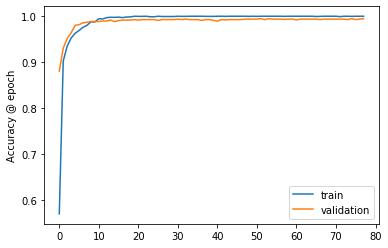

In [44]:
# Let's check how it performs on validation set!
predictions, ground_truth = evaluate_model(model, train_dataset, val_indices)
precision, recall, f1 = binary_classification_metrics(predictions, ground_truth)
print("F1: {0:.3f}, Precision: {1:.3f}, Recall: {2:.3f}".format(f1, precision, recall))

plot_history(loss_history, train_history, val_history)
# print(predictions)

In [45]:
f1


0.9335664335664335

## Визуализируйте ошибки лучшей модели

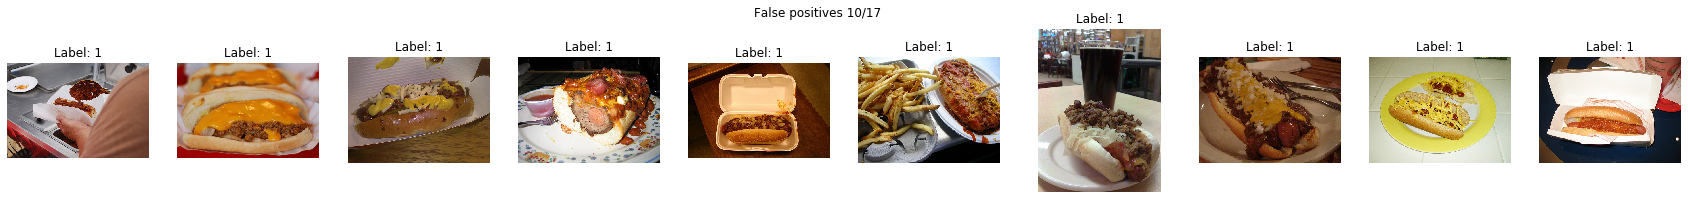

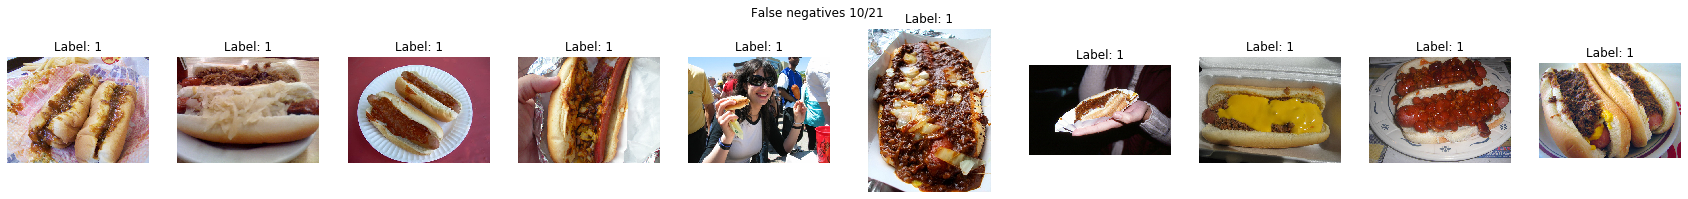

In [46]:
false_positive_indices, false_negatives_indices = false_pos_neg(predictions, ground_truth)

visualize_samples(orig_dataset, false_positive_indices, "False positives")
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")

# Необязательное задание с большой звездочкой

Поучавствуйте в Kaggle In-Class Hot Dog Recognition Challenge!  
Это соревнование сделано специально для курса и в нем учавствуют только те, кто проходит курс.

В нем участники соревнуются в качестве натренированных моделей, загружая на сайт предсказания своих моделей на тестовой выборке. Разметка тестовой выборке участникам недоступна.
Более подробно о правилах соревнования ниже.

Те, кто проходят курс лично, за высокое место в соревновании получат дополнительные баллы.

Здесь уже можно использовать и другие базовые архитектуры кроме `resnet18`, и ансамбли, и другие трюки тренировки моделей.

Вот ссылка на соревнование:
https://www.kaggle.com/c/hotdogornot

In [47]:
# del loss_history, train_history, val_history
torch.cuda.empty_cache()

In [48]:


image_id = []
predictions = []
model.eval()

for x,_,id_img in test_loader:
    with torch.no_grad():
        output = model.forward(x.to(device))
        output_prediction = torch.argmax(output, dim=1).cpu().numpy()
        
        for i in range(output_prediction.shape[0]):
            #print(output_prediction.shape)
            image_id.append(id_img[i])
            p = 0
            if output_prediction[i] > 0:
                p = 1
            predictions.append(p)

In [49]:
import pandas as pd
data = pd.DataFrame()

data['image_id'] = image_id
data['label'] = predictions

# data.explode(['img','predictions']).reset_index(level=0)
data.describe()

,label
count,1150.000000
mean,0.316522
std,0.465321
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [50]:
# https://stackoverflow.com/questions/20845213/how-to-avoid-python-pandas-creating-an-index-in-a-saved-csv
data.to_csv('subm.csv', index = False)

### Небольшое введение в Kaggle для тех, кто не слышал об этой платформе раньше

В основе своей Kaggle - это платформа для проведения соревнований по машинному обучению. Появилась она в 2010 и, пожалуй, стала самой популярной и известной из всех существующих площадок по машинному обучению. Надо сказать, что Kaggle - это не только соревнования, но и сообщество людей, увлеченных машинным обучением. А судя по Википедии, в 2017 году отметка зарегистрированных пользователей перевалила за миллион. Есть там и обучающие материалы, возможность задавать вопросы, делиться кодом и идеями - просто мечта. 

### Как проходят соревнования? 
Обычно участники скачивают данные для обучения моделей (train data), чтобы затем делать предсказания на тестовых данных (test data). Обучающая выборка содержит как сами данные, так и правильные метки (значения зависимой переменной), чтобы можно было обучить модель. Но тестовые данные ответа не содержат - и нашей целью является предсказание меток по имеющимся данным. Файл с ответами для каждого наблюдения из тестовой выборки загружается на Kaggle и оценивается в соответствии с выбранной метрикой соревнования, а результат является публичным и показывается в общей таблице (ее называют еще лидербордом - leaderboard) - чтобы появилось желание посоревноваться и создать еще более сильную модель. В "настоящих" соревнованиях, которые проходят на Kaggle, есть и денежное вознаграждение для тех участников, кто занимает первые места на лидерборде. Например, в [этом](https://www.kaggle.com/c/zillow-prize-1#description) соревновании, человек, занявший первое место, получил около 1 000 000 долларов. 

Тестовые данные делятся случайным образом в некоторой пропорции. И пока соревнование идет, на лидерборде показываются очки и рейтинг участников только по одной части (Public Leaderboard). А вот когда соревнование заканчивается, то рейтинг участников составляется по второй части тестовых данных (Private Leaderboard). И часто можно видеть, как люди занимавшие первые места на публичной части тестовых данных, оказываются далеко не первыми на закрытой части тестовых данных. Зачем это сделано? Есть несколько причин, но, пожалуй, самой фундаментальной является идея недообучения-переобучения. Всегда возможно, что наша модель настроилась на конкретную выборку, но как она поведет себя на тех данных, которые еще не видела? Разбиение тестовых данных на публичную и скрытую части сделано для того, чтобы отобрать модели, которые имеют большую обобщающую способность. Одним из лозунгов участников соревнований стал "Доверяйте своей локальной кросс-валидации" (Trust your CV!). Есть очень большой соблазн оценивать свою модель по публичной части лидерборда, но лучшей стратегией будет выбирать ту модель, которая дает лучшую метрику на кросс-валидации на обучающей выборке. 

В нашем соревновании публичная часть лидерборда составляет 30%, а скрытая 70%. Вы можете делать до двух попыток в день, а оцениваться попытки будут по F1-мере. Удачи и доверяйте своей локальной валидации! В конце соревнования у вас будет возможность выбрать 2 из всех совершенных попыток - лучшая из этих двух и будет засчитана вам на скрытой части тестовых данных.